<a href="https://colab.research.google.com/github/SamWalter5/AIMoviePredictor/blob/main/CAP4630_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and imports

In [1]:
!pip install pandas scikit-learn tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Loading the dataset

In [2]:
file_path = "/content/movie_data.csv"
df = pd.read_csv(file_path)

df_raw = df.copy()

print("Shape: ", df.shape)
df.head()

Shape:  (4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


Choose target and cleaning

In [3]:
df = df.dropna(subset = ['budget', 'revenue'])
df = df[df['budget'] > 0]

df['success'] = (df['revenue'] >= 1.2 * df['budget']).astype(int)

TARGET_COLUMN = "success"

df = df.dropna(subset = [TARGET_COLUMN])

cols_to_drop = [
    "id", "homepage", "original_title", "overview", "production_companies",
    "production_countries", "spoken_languages", "status", "tagline", "title",
    "keywords", "genres", "release_date"
]

for col in cols_to_drop:
    if col in df.columns:
        df = df.drop(columns = [col])

print("Columns after dropping: ", df.columns.tolist())

Columns after dropping:  ['budget', 'original_language', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'success']


Fixing missing runtime values

In [4]:
if 'runtime' in df.columns:
    df['runtime'] = df['runtime'].fillna(df['runtime'].median())

Splitting into features and labels

In [5]:
X = df.drop(columns = [TARGET_COLUMN, "revenue"])

y = df[TARGET_COLUMN].astype(int)

Hot-one encoding

In [6]:
X = pd.get_dummies(X, drop_first = True)

feature_cols = X.columns

print("Feature shape after one-hot encoding: ", X.shape)

Feature shape after one-hot encoding:  (3766, 34)


Splitting the data

In [7]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size = 0.2, random_state = 42, stratify = y_train_full
)

print("Train: ", X_train.shape, y_train.shape)
print("Val: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train:  (2409, 34) (2409,)
Val:  (603, 34) (603,)
Test:  (754, 34) (754,)


Scaling

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Building the DNN

In [9]:
input_dim = X_train_scaled.shape[1]

model = Sequential([
    Dense(128, activation = 'relu', input_shape = (input_dim,)),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849 (58.00 KB)

 Trainable params: 14,849 (58.00 KB)

 Non-trainable params: 0 (0.00 B)

Compiling the model

In [10]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

Callbacks

In [11]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 3,
    min_lr = 1e-6,
    verbose = 1
)

Training/fitting the model

In [12]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data = (X_val_scaled, y_val),
    epochs = 50,
    batch_size = 32,
    callbacks = [early_stopping, reduce_lr],
    verbose = 1
)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5989 - loss: 0.6742 - val_accuracy: 0.7247 - val_loss: 0.5818 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7201 - loss: 0.5606 - val_accuracy: 0.7297 - val_loss: 0.5498 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7194 - loss: 0.5476 - val_accuracy: 0.7496 - val_loss: 0.5256 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7507 - loss: 0.5145 - val_accuracy: 0.7479 - val_loss: 0.5320 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7664 - loss: 0.4991 - val_accuracy: 0.7612 - val_loss: 0.5168 - learning_rate: 0.0010
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7425 - loss: 0.5265 - val_accuracy: 0.7629 - val_loss: 0.5239 - learning_rate: 0.0010
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7484 - loss: 0.5185 - val_accuracy:

Plotting training vs validation accuracy

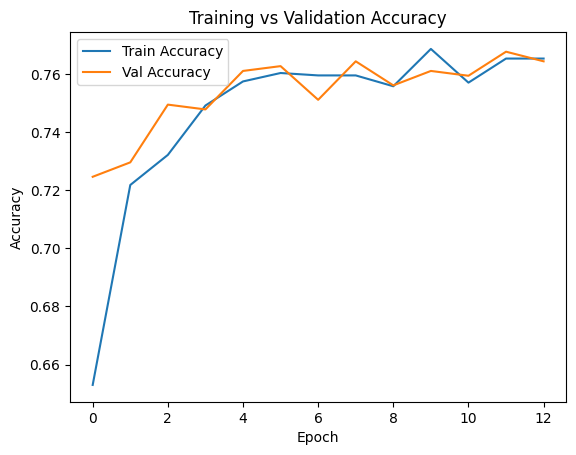

In [13]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

Evaluating on the testing set

In [14]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose = 0)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.747


Classification report and confusion matrix

In [15]:
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob >= 0.5).astype(int).ravel()

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy:  0.746684350132626

Classification report:

              precision    recall  f1-score   support

           0       0.69      0.64      0.67       296
           1       0.78      0.81      0.80       458

    accuracy                           0.75       754
   macro avg       0.73      0.73      0.73       754
weighted avg       0.74      0.75      0.74       754

Confusion Matrix: 
[[190 106]
 [ 85 373]]


Converting runtime to hours and minutes

In [16]:
def format_runtime(minutes):
    minutes = float(minutes)
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f"{hours}h {mins}m"

Language converter

In [17]:
LANGUAGE_MAP = {
    "en" : "English",
    "fr" : "French",
    "es" : "Spanish",
    "de" : "German",
    "it" : "Italian",
    "ja" : "Japanese",
    "zh" : "Chinese",
    "ko" : "Korean",
    "ru" : "Russian",
    "pt" : "Portuguese",
    "hi" : "Hindi"
}

def get_language_name(code):
    code = str(code).lower()
    return LANGUAGE_MAP.get(code, code)

Prediction function

In [18]:
def predict_movie_success(budget, popularity, runtime, vote_average, vote_count, original_language = 'en'):
    data = {
        'budget' : [budget],
        'popularity' : [popularity],
        'runtime' : [runtime],
        'vote_average' : [vote_average],
        'vote_count' : [vote_count],
        'original_language' : [original_language],
    }

    df_new = pd.DataFrame(data)

    X_new = pd.get_dummies(df_new, drop_first = True)

    X_new = X_new.reindex(columns = feature_cols, fill_value = 0)

    X_new_scaled = scaler.transform(X_new)

    prob_success = float(model.predict(X_new_scaled)[0][0])

    label = "LIKELY SUCCESSFULL ✅" if prob_success >= 0.5 else "LIKELY NOT SUCCESSFULL ❌"

    print("----- Movie Prediction -----")
    print(f"Budget:             ${budget:,.0f}")
    print(f"Popularity:         {int(popularity):,}")
    print(f"Runtime:            {format_runtime(runtime)} ({runtime} minutes)")
    print(f"Vote Average:       {vote_average:.1f} / 10")
    print(f"Vote Count:         {int(vote_count):,}")
    print(f"Original Language:  {get_language_name(original_language)}")
    print("-----------------------------")
    print(f"Predicted probability of success: {prob_success * 100:.0f}%")
    print(f"Prediction: {label}")

???

In [19]:
def predict_movie_by_title(title_query):
    matches = df_raw[df_raw['title'].str.lower() == title_query.lower()]

    if matches.empty:
        matches = df_raw[df_raw['title'].str.lower().str.contains(title_query.lower(), na = False)]

    if matches.empty:
        print(f"No movie found with title: '{title_query}'")
        return

    if len(matches) > 1:
        print(f"Found {len(matches)} matches, using the first one: ")
    row = matches.iloc[0]

    budget = float(row['budget']) if not pd.isna(row['budget']) else 0.0
    popularity = float(row['popularity']) if not pd.isna(row['popularity']) else 0.0
    runtime = float(row['runtime']) if not pd.isna(row['runtime']) else df['runtime'].median()
    vote_average = float(row['vote_average']) if not pd.isna(row['vote_average']) else 0.0
    vote_count = float(row['vote_count']) if not pd.isna(row['vote_count']) else 0.0
    original_language = row['original_language'] if not pd.isna(row['original_language']) else 'en'

    print(f"\n=== Using movie: {row['title']} (id = {row['id']}) ===")

    predict_movie_success(
        budget = budget,
        popularity = popularity,
        runtime = runtime,
        vote_average = vote_average,
        vote_count = vote_count,
        original_language = original_language
    )

Function ???

In [20]:
predict_movie_success(
    budget = 150000000,
    popularity = 80.0,
    runtime = 140,
    vote_average = 7.5,
    vote_count = 5000,
    original_language = 'en'
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
----- Movie Prediction -----
Budget:             $150,000,000
Popularity:         80
Runtime:            2h 20m (140 minutes)
Vote Average:       7.5 / 10
Vote Count:         5,000
Original Language:  English
-----------------------------
Predicted probability of success: 96%
Prediction: LIKELY SUCCESSFULL ✅


???

In [21]:
import string

print("===== Movies you can type in (A-Z) =====\n")

all_titles = sorted(df_raw['title'].dropna().unique())

groups = {letter: [] for letter in string.ascii_uppercase}

for title in all_titles:
    first = title[0].upper()
    if first in groups:
        groups[first].append(title)
    else:
        groups.setdefault("#", []).append(title)

for letter in groups:
    if groups[letter]:
        print(f"\n--- {letter} ---")
        print(", ".join(groups[letter]))

print("\n=========================================")
print(f"Total movies: {len(all_titles)}")

===== Movies you can type in (A-Z) =====


--- A ---
A Beautiful Mind, A Beginner's Guide to Snuff, A Better Life, A Bridge Too Far, A Bug's Life, A Charlie Brown Christmas, A Christmas Carol, A Christmas Story, A Cinderella Story, A Civil Action, A Cock and Bull Story, A Dangerous Method, A Dog Of Flanders, A Dog's Breakfast, A Farewell to Arms, A Few Good Men, A Fine Step, A Fistful of Dollars, A Funny Thing Happened on the Way to the Forum, A Good Day to Die Hard, A Good Year, A Guy Named Joe, A Guy Thing, A Hard Day's Night, A Haunted House, A Haunted House 2, A History of Violence, A Home at the End of the World, A Knight's Tale, A LEGO Brickumentary, A League of Their Own, A Lonely Place to Die, A Lot Like Love, A Low Down Dirty Shame, A Madea Christmas, A Man Apart, A Man for All Seasons, A Mighty Heart, A Mighty Wind, A Million Ways to Die in the West, A Monster in Paris, A Most Violent Year, A Most Wanted Man, A Night at the Roxbury, A Nightmare on Elm Street, A Nightmare on E

Input movie title

In [22]:
predict_movie_by_title("Happy Feet")


=== Using movie: Happy Feet (id = 9836) ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
----- Movie Prediction -----
Budget:             $100,000,000
Popularity:         37
Runtime:            1h 48m (108.0 minutes)
Vote Average:       5.9 / 10
Vote Count:         1,410
Original Language:  English
-----------------------------
Predicted probability of success: 65%
Prediction: LIKELY SUCCESSFULL ✅
